## Autoencoder 自编码器     
自编码器是一种执行数据压缩的网络架构，其中压缩和解压缩功能是从数据本身学习而来的。  

自编码器的一般思路是将你的输入数据传递给编码器，以创建输入的压缩表示，然后再将该表示传递给解码器，以获得重建后的数据。编码器和解码器都是用神经网络构建的。整个网络的训练方式是最小化输入和输出之间的差异，像正常情况下一样，这样，中间层将是输入数据的压缩表示，你可以从它构建原始数据。当然，会有一些信息丢失，基本上是因为单元减少了。  

在实践中，自编码器的压缩性能实际上比JPEG,MP3和MPEg或视频等传统方法要差，并且，自编码器在泛化到其训练数据集之外的数据集方面有困难，但近来，人们发现了它们在**图像去噪和降维方面**的用途。 


Autoencoder 是一种无监督的学习算法，主要用于数据的降维或者特征的抽取。在深度学习中，autoencoder可用于在训练阶段开始前，确定权重矩阵W的初始值。 它使用了反向传播算法，并让目标值等于输入值。   
我们构建一个尝试生成其输入数据的网络，但该网络具有一个窄的隐藏层用作输入数据的压缩表示。如下图：

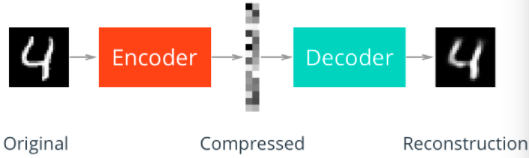

In [9]:
from IPython.display import Image
Image("23.png")

自动编码器是一种数据的压缩算法，其中数据的压缩和解压缩是数据相关的、有损的、从样本中自动学习的。在大部分提到自动编码器的场合，压缩和解压缩的函数是通过神经网络实现的。

如下例：   
### Convolutional Autoencoder(卷积自编码器)
使用MNIST数据集，我们使用卷积层提高自编码性能。加载模块和数据。

In [10]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt  

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


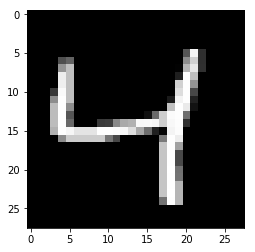

In [12]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28,28)),cmap='Greys_r')

### 网络体系结构   

网络的编码器部分将是一个典型的卷积金字塔。每个卷积层将遵循一个最大池层，以减少层的维数。解码器也许对你来说是新事物。解码器需要从窄表示转换成宽的重构图像。例如，表示可能是一个4x4x8最大池层。这是编码器的输出，也是解码器的输入。我们想从解码器得到一个28x28x1图像，所以需要从狭窄的解码器的输入层反向运作。下面的网络示意图如下所示。  

![Convolutional Autoencoder](assets/convolutional_autoencoder.png)  
在这里，我们最后的编码层大小4x4x8 = 128。原始图像的大小28x28 = 784，所以编码向量是大约16%的原始图像的大小。这些只是建议的每个层的大小。请随意更改深度和大小，但请记住，我们的目标是找到输入数据的一个表示形式。

 #### 解码器将会做什么
解码器具有这些“上采样”层，你可能没有见过。首先，我将讨论一下哪些层不是。通常，你会看到反卷积-用来增加层的宽度和高度层。它们的工作原理几乎与卷积层完全相同，但是它反转了。在输入层的一步会在反卷积层形成一大步。例如，如果在输入层你有一个3x3的卷积核，一个3x3的patch将会减少为在卷积层的一个单元。相对而言，在输入层的一个单元，将会在反卷积层扩大成3x3的patch。反卷积是通常被称为“transpose convolution(转置卷积)”在tensorflow API中，[`tf.nn.conv2d_transpose`]。  
>- 缩小图像（或称为下采样（subsampled）或降采样（downsampled））的主要目的有两个：1、使得图像符合显示区域的大小；2、生成对应图像的缩略图。
>- 放大图像（或称为上采样（upsampling）或图像插值（interpolating））的主要目的是放大原图像,从而可以显示在更高分辨率的显示设备上。  

然而，在最终的图像中，反卷积层可能会导致棋盘格子状的伪影（artifact）。这是由于内核重叠造成的，可以通过设置步长和内核大小来避免这些重叠。这些棋盘效应可以通过在卷积层后使用最近邻或双线性插值（上采样）避免。在TensorFlow，在一个卷积层之后通过[`tf.image.resize_nearest_neighbor`]这是很容易做到的。  
> 练习：  建立上面所示的网络。请记住，步长为1和“SAME”填充的卷积层不会降低高度和宽度。那就是，如果输入的是28x28和卷积层步长为1和“SAME”的填充，卷积层也会是28x28。最大池层是用来减少宽度和高度的。步长为2将以2为单位缩小尺寸。Odena等人声称最近邻插值效果是最好的上采样，所以要作为一个参数使用`tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]

In [15]:
inputs_ = tf.placeholder(tf.float32,(None,28,28,1),name='inputs')
targets_=tf.placeholder(tf.float32,(None,28,28,1),name='target')

# Encoder 
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same',activation =tf.nn.relu)
# Now 28x28x16  
maxpool1 = tf.layers.max_pooling2d(conv1,(2,2),(2,2),padding='same')
# Now 14x14x16 
conv2 = tf.layers.conv2d(maxpool1, 8,(3,3),padding='same',activation=tf.nn.relu)
# Now 14x14x8
maxpool2 =tf.layers.max_pooling2d(conv2,(2,2),(2,2),padding='same')
# Now 7x7x8  
conv3= tf.layers.conv2d(maxpool2,8, (3,3),padding='same',activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3,(2,2),(2,2),padding='same')
# Now 4x4x8

# Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded,(7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8,(3,3),padding='same',activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4,(14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2,8,(3,3),padding='same',activation=tf.nn.relu)
# Now 14x14x8
upsample3=tf.image.resize_nearest_neighbor(conv5,(28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3,16,(3,3),padding='same',activation=tf.nn.relu)
# Now 28x28x16  
logits=tf.layers.conv2d(conv6,1,(3,3),padding='same',activation=tf.nn.relu)

# Now 28x28x1
decoded = tf.nn.sigmoid(logits,name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_,logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

### Training 
和以前一样，在这里训练网络。使用28x28x1数列，而不是拉直的图像。

In [16]:
sess = tf.Session()

In [17]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1,28,28,1))  
        batch_cost, _ = sess.run([cost,opt],feed_dict={inputs_:imgs,targets_:imgs})
        
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6947
Epoch: 1/20... Training loss: 0.6935
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
E

Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6933
E

Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
Epoch: 2/20... Training loss: 0.6933
E

Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
E

Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 3/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
E

Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
Epoch: 4/20... Training loss: 0.6933
E

Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
Epoch: 5/20... Training loss: 0.6933
E

Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
E

Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 6/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
E

Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
Epoch: 7/20... Training loss: 0.6933
E

Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
Epoch: 8/20... Training loss: 0.6933
E

Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
E

Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
Epoch: 9/20... Training loss: 0.6933
E

Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20... Training loss: 0.6933
Epoch: 10/20

Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20... Training loss: 0.6933
Epoch: 11/20

Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20

Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20... Training loss: 0.6933
Epoch: 12/20

Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20... Training loss: 0.6933
Epoch: 13/20

Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20

Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 14/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20

Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20... Training loss: 0.6933
Epoch: 15/20

Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20... Training loss: 0.6933
Epoch: 16/20

Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20

Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20... Training loss: 0.6933
Epoch: 17/20

Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20... Training loss: 0.6933
Epoch: 18/20

Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20

Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 19/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20

Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20... Training loss: 0.6933
Epoch: 20/20

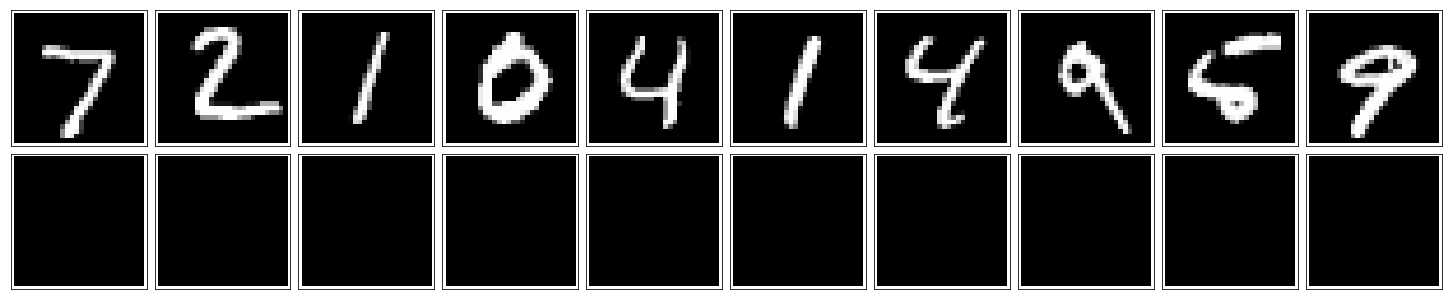

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=10,sharex=True,sharey=True,figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded,feed_dict={inputs_: in_imgs.reshape((10,28,28,1))})
for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
            
fig.tight_layout(pad=0.1)

In [26]:
sess.close()

## Denoising(降噪)
正如我之前提到的，在实际中，构建autoencoders不太有用。然而，在训练噪音图像网络中，它们可以非常成功地对图像进行去噪。我们可以通过在训练图像中加入高斯噪声来创建噪声图像，然后将这些值处理在0到1之间。我们将使用噪声图像作为输入，原始的，干净的图像作为目标。下面是产生和去噪图像的一个例子。   
![Denoising autoencoder](assets/denoising.png)  
由于这是网络中比较困难的问题，我们希望在这里使用更深层的卷积层，更多的特征映射。我建议在编码器的卷积层使用像32-32-16的深度，在解码器使用同一深度后退。否则，架构与以前相同。   

**练习**

In [31]:
inputs_ = tf.placeholder(tf.float32,(None,28,28,1),name='inputs')
targets_=tf.placeholder(tf.float32,(None,28,28,1),name='targets')

## Encoder
conv1=tf.layers.conv2d(inputs_, 32,(3,3),padding='same',activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1,(2,2),(2,2),padding='same')
# Now 14x14x32
conv2=tf.layers.conv2d(maxpool1,32,(3,3),padding='same',activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2,(2,2),(2,2),padding='same')
# Now 7x7x32
conv3=tf.layers.conv2d(maxpool2,16,(3,3),padding='same',activation=tf.nn.relu)
# Now 7x7x16
encoded=tf.layers.max_pooling2d(conv3,(2,2),(2,2),padding='same')
# Now 4x4x16

# Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded,(7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1,16,(3,3),padding='same',activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4,(14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2,32,(3,3),padding='same',activation=tf.nn.relu)
# Now 14x14x32
upsample3=tf.image.resize_nearest_neighbor(conv5,(28,28))
# Now 28x28x32
conv6=tf.layers.conv2d(upsample3,32,(3,3),padding='same',activation=tf.nn.relu)

# Now 28x28x32
logits = tf.layers.conv2d(conv6,1,(3,3),padding='same',activation=None)
decoded=tf.nn.sigmoid(logits,name='decoded')

loss=tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_,logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [32]:
sess = tf.Session()

In [33]:
epochs=100
batch_size=200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())

for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        # Get images from batch
        imgs = batch[0].reshape((-1,28,28,1))
        # Add random noise to the input images
        noisy_imgs=imgs+noise_factor*np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs,0.,1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _=sess.run([cost,opt],feed_dict={inputs_:noisy_imgs,
                                                    targets_:imgs})
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.6830
Epoch: 1/100... Training loss: 0.6556
Epoch: 1/100... Training loss: 0.6207
Epoch: 1/100... Training loss: 0.5762
Epoch: 1/100... Training loss: 0.5275
Epoch: 1/100... Training loss: 0.4912
Epoch: 1/100... Training loss: 0.4928
Epoch: 1/100... Training loss: 0.5117
Epoch: 1/100... Training loss: 0.5062
Epoch: 1/100... Training loss: 0.4856
Epoch: 1/100... Training loss: 0.4628
Epoch: 1/100... Training loss: 0.4484
Epoch: 1/100... Training loss: 0.4399
Epoch: 1/100... Training loss: 0.4347
Epoch: 1/100... Training loss: 0.4275
Epoch: 1/100... Training loss: 0.4187
Epoch: 1/100... Training loss: 0.4089
Epoch: 1/100... Training loss: 0.4006
Epoch: 1/100... Training loss: 0.3917
Epoch: 1/100... Training loss: 0.3813
Epoch: 1/100... Training loss: 0.3701
Epoch: 1/100... Training loss: 0.3606
Epoch: 1/100... Training loss: 0.3517
Epoch: 1/100... Training loss: 0.3435
Epoch: 1/100... Training loss: 0.3350
Epoch: 1/100... Training loss: 0.3272
Epoch: 1/100

Epoch: 1/100... Training loss: 0.1761
Epoch: 1/100... Training loss: 0.1763
Epoch: 1/100... Training loss: 0.1747
Epoch: 1/100... Training loss: 0.1736
Epoch: 1/100... Training loss: 0.1718
Epoch: 1/100... Training loss: 0.1734
Epoch: 1/100... Training loss: 0.1718
Epoch: 1/100... Training loss: 0.1723
Epoch: 1/100... Training loss: 0.1725
Epoch: 1/100... Training loss: 0.1723
Epoch: 1/100... Training loss: 0.1727
Epoch: 1/100... Training loss: 0.1712
Epoch: 1/100... Training loss: 0.1717
Epoch: 1/100... Training loss: 0.1719
Epoch: 1/100... Training loss: 0.1716
Epoch: 1/100... Training loss: 0.1713
Epoch: 1/100... Training loss: 0.1717
Epoch: 1/100... Training loss: 0.1710
Epoch: 1/100... Training loss: 0.1704
Epoch: 1/100... Training loss: 0.1713
Epoch: 1/100... Training loss: 0.1698
Epoch: 1/100... Training loss: 0.1711
Epoch: 1/100... Training loss: 0.1696
Epoch: 1/100... Training loss: 0.1704
Epoch: 1/100... Training loss: 0.1701
Epoch: 1/100... Training loss: 0.1706
Epoch: 1/100

Epoch: 2/100... Training loss: 0.1514
Epoch: 2/100... Training loss: 0.1513
Epoch: 2/100... Training loss: 0.1524
Epoch: 2/100... Training loss: 0.1520
Epoch: 2/100... Training loss: 0.1509
Epoch: 2/100... Training loss: 0.1503
Epoch: 2/100... Training loss: 0.1493
Epoch: 2/100... Training loss: 0.1510
Epoch: 2/100... Training loss: 0.1515
Epoch: 2/100... Training loss: 0.1507
Epoch: 2/100... Training loss: 0.1490
Epoch: 2/100... Training loss: 0.1508
Epoch: 2/100... Training loss: 0.1497
Epoch: 2/100... Training loss: 0.1510
Epoch: 2/100... Training loss: 0.1496
Epoch: 2/100... Training loss: 0.1496
Epoch: 2/100... Training loss: 0.1491
Epoch: 2/100... Training loss: 0.1489
Epoch: 2/100... Training loss: 0.1498
Epoch: 2/100... Training loss: 0.1496
Epoch: 2/100... Training loss: 0.1486
Epoch: 2/100... Training loss: 0.1506
Epoch: 2/100... Training loss: 0.1506
Epoch: 2/100... Training loss: 0.1496
Epoch: 2/100... Training loss: 0.1499
Epoch: 2/100... Training loss: 0.1486
Epoch: 2/100

Epoch: 3/100... Training loss: 0.1373
Epoch: 3/100... Training loss: 0.1394
Epoch: 3/100... Training loss: 0.1391
Epoch: 3/100... Training loss: 0.1386
Epoch: 3/100... Training loss: 0.1395
Epoch: 3/100... Training loss: 0.1390
Epoch: 3/100... Training loss: 0.1376
Epoch: 3/100... Training loss: 0.1387
Epoch: 3/100... Training loss: 0.1401
Epoch: 3/100... Training loss: 0.1371
Epoch: 3/100... Training loss: 0.1376
Epoch: 3/100... Training loss: 0.1387
Epoch: 3/100... Training loss: 0.1392
Epoch: 3/100... Training loss: 0.1368
Epoch: 3/100... Training loss: 0.1378
Epoch: 3/100... Training loss: 0.1376
Epoch: 3/100... Training loss: 0.1376
Epoch: 3/100... Training loss: 0.1379
Epoch: 3/100... Training loss: 0.1397
Epoch: 3/100... Training loss: 0.1386
Epoch: 3/100... Training loss: 0.1365
Epoch: 3/100... Training loss: 0.1389
Epoch: 3/100... Training loss: 0.1396
Epoch: 3/100... Training loss: 0.1389
Epoch: 3/100... Training loss: 0.1368
Epoch: 3/100... Training loss: 0.1386
Epoch: 3/100

Epoch: 3/100... Training loss: 0.1305
Epoch: 3/100... Training loss: 0.1324
Epoch: 3/100... Training loss: 0.1313
Epoch: 3/100... Training loss: 0.1310
Epoch: 3/100... Training loss: 0.1299
Epoch: 3/100... Training loss: 0.1326
Epoch: 3/100... Training loss: 0.1315
Epoch: 3/100... Training loss: 0.1307
Epoch: 3/100... Training loss: 0.1321
Epoch: 3/100... Training loss: 0.1317
Epoch: 3/100... Training loss: 0.1297
Epoch: 3/100... Training loss: 0.1305
Epoch: 3/100... Training loss: 0.1310
Epoch: 3/100... Training loss: 0.1302
Epoch: 3/100... Training loss: 0.1330
Epoch: 3/100... Training loss: 0.1319
Epoch: 3/100... Training loss: 0.1314
Epoch: 3/100... Training loss: 0.1317
Epoch: 3/100... Training loss: 0.1307
Epoch: 3/100... Training loss: 0.1330
Epoch: 3/100... Training loss: 0.1305
Epoch: 3/100... Training loss: 0.1320
Epoch: 3/100... Training loss: 0.1306
Epoch: 3/100... Training loss: 0.1296
Epoch: 3/100... Training loss: 0.1298
Epoch: 3/100... Training loss: 0.1297
Epoch: 3/100

Epoch: 4/100... Training loss: 0.1253
Epoch: 4/100... Training loss: 0.1252
Epoch: 4/100... Training loss: 0.1269
Epoch: 4/100... Training loss: 0.1272
Epoch: 4/100... Training loss: 0.1242
Epoch: 4/100... Training loss: 0.1261
Epoch: 4/100... Training loss: 0.1271
Epoch: 4/100... Training loss: 0.1276
Epoch: 4/100... Training loss: 0.1252
Epoch: 4/100... Training loss: 0.1244
Epoch: 4/100... Training loss: 0.1268
Epoch: 4/100... Training loss: 0.1260
Epoch: 4/100... Training loss: 0.1260
Epoch: 4/100... Training loss: 0.1243
Epoch: 4/100... Training loss: 0.1249
Epoch: 4/100... Training loss: 0.1251
Epoch: 4/100... Training loss: 0.1275
Epoch: 4/100... Training loss: 0.1280
Epoch: 4/100... Training loss: 0.1233
Epoch: 4/100... Training loss: 0.1249
Epoch: 4/100... Training loss: 0.1260
Epoch: 4/100... Training loss: 0.1255
Epoch: 4/100... Training loss: 0.1268
Epoch: 4/100... Training loss: 0.1274
Epoch: 4/100... Training loss: 0.1240
Epoch: 4/100... Training loss: 0.1257
Epoch: 4/100

Epoch: 5/100... Training loss: 0.1231
Epoch: 5/100... Training loss: 0.1227
Epoch: 5/100... Training loss: 0.1203
Epoch: 5/100... Training loss: 0.1223
Epoch: 5/100... Training loss: 0.1236
Epoch: 5/100... Training loss: 0.1221
Epoch: 5/100... Training loss: 0.1215
Epoch: 5/100... Training loss: 0.1223
Epoch: 5/100... Training loss: 0.1228
Epoch: 5/100... Training loss: 0.1226
Epoch: 5/100... Training loss: 0.1219
Epoch: 5/100... Training loss: 0.1210
Epoch: 5/100... Training loss: 0.1211
Epoch: 5/100... Training loss: 0.1202
Epoch: 5/100... Training loss: 0.1218
Epoch: 5/100... Training loss: 0.1206
Epoch: 5/100... Training loss: 0.1212
Epoch: 5/100... Training loss: 0.1203
Epoch: 5/100... Training loss: 0.1214
Epoch: 5/100... Training loss: 0.1213
Epoch: 5/100... Training loss: 0.1213
Epoch: 5/100... Training loss: 0.1221
Epoch: 5/100... Training loss: 0.1208
Epoch: 5/100... Training loss: 0.1223
Epoch: 5/100... Training loss: 0.1220
Epoch: 5/100... Training loss: 0.1201
Epoch: 5/100

Epoch: 6/100... Training loss: 0.1188
Epoch: 6/100... Training loss: 0.1184
Epoch: 6/100... Training loss: 0.1192
Epoch: 6/100... Training loss: 0.1191
Epoch: 6/100... Training loss: 0.1175
Epoch: 6/100... Training loss: 0.1182
Epoch: 6/100... Training loss: 0.1186
Epoch: 6/100... Training loss: 0.1185
Epoch: 6/100... Training loss: 0.1169
Epoch: 6/100... Training loss: 0.1192
Epoch: 6/100... Training loss: 0.1181
Epoch: 6/100... Training loss: 0.1181
Epoch: 6/100... Training loss: 0.1185
Epoch: 6/100... Training loss: 0.1178
Epoch: 6/100... Training loss: 0.1183
Epoch: 6/100... Training loss: 0.1184
Epoch: 6/100... Training loss: 0.1186
Epoch: 6/100... Training loss: 0.1182
Epoch: 6/100... Training loss: 0.1195
Epoch: 6/100... Training loss: 0.1187
Epoch: 6/100... Training loss: 0.1189
Epoch: 6/100... Training loss: 0.1184
Epoch: 6/100... Training loss: 0.1196
Epoch: 6/100... Training loss: 0.1181
Epoch: 6/100... Training loss: 0.1186
Epoch: 6/100... Training loss: 0.1189
Epoch: 6/100

Epoch: 6/100... Training loss: 0.1160
Epoch: 6/100... Training loss: 0.1164
Epoch: 6/100... Training loss: 0.1170
Epoch: 6/100... Training loss: 0.1167
Epoch: 6/100... Training loss: 0.1156
Epoch: 6/100... Training loss: 0.1148
Epoch: 6/100... Training loss: 0.1157
Epoch: 6/100... Training loss: 0.1144
Epoch: 6/100... Training loss: 0.1164
Epoch: 6/100... Training loss: 0.1182
Epoch: 6/100... Training loss: 0.1153
Epoch: 6/100... Training loss: 0.1153
Epoch: 6/100... Training loss: 0.1168
Epoch: 6/100... Training loss: 0.1146
Epoch: 6/100... Training loss: 0.1174
Epoch: 6/100... Training loss: 0.1153
Epoch: 6/100... Training loss: 0.1169
Epoch: 6/100... Training loss: 0.1167
Epoch: 6/100... Training loss: 0.1158
Epoch: 6/100... Training loss: 0.1170
Epoch: 6/100... Training loss: 0.1153
Epoch: 6/100... Training loss: 0.1151
Epoch: 6/100... Training loss: 0.1170
Epoch: 6/100... Training loss: 0.1167
Epoch: 6/100... Training loss: 0.1169
Epoch: 6/100... Training loss: 0.1158
Epoch: 6/100

Epoch: 7/100... Training loss: 0.1161
Epoch: 7/100... Training loss: 0.1151
Epoch: 7/100... Training loss: 0.1151
Epoch: 7/100... Training loss: 0.1140
Epoch: 7/100... Training loss: 0.1151
Epoch: 7/100... Training loss: 0.1154
Epoch: 7/100... Training loss: 0.1144
Epoch: 7/100... Training loss: 0.1133
Epoch: 7/100... Training loss: 0.1155
Epoch: 7/100... Training loss: 0.1141
Epoch: 7/100... Training loss: 0.1150
Epoch: 7/100... Training loss: 0.1147
Epoch: 7/100... Training loss: 0.1126
Epoch: 7/100... Training loss: 0.1153
Epoch: 7/100... Training loss: 0.1140
Epoch: 7/100... Training loss: 0.1141
Epoch: 7/100... Training loss: 0.1149
Epoch: 7/100... Training loss: 0.1158
Epoch: 7/100... Training loss: 0.1144
Epoch: 7/100... Training loss: 0.1143
Epoch: 7/100... Training loss: 0.1140
Epoch: 7/100... Training loss: 0.1141
Epoch: 7/100... Training loss: 0.1145
Epoch: 7/100... Training loss: 0.1160
Epoch: 7/100... Training loss: 0.1154
Epoch: 7/100... Training loss: 0.1145
Epoch: 7/100

Epoch: 8/100... Training loss: 0.1115
Epoch: 8/100... Training loss: 0.1118
Epoch: 8/100... Training loss: 0.1114
Epoch: 8/100... Training loss: 0.1119
Epoch: 8/100... Training loss: 0.1113
Epoch: 8/100... Training loss: 0.1125
Epoch: 8/100... Training loss: 0.1118
Epoch: 8/100... Training loss: 0.1124
Epoch: 8/100... Training loss: 0.1114
Epoch: 8/100... Training loss: 0.1127
Epoch: 8/100... Training loss: 0.1129
Epoch: 8/100... Training loss: 0.1130
Epoch: 8/100... Training loss: 0.1124
Epoch: 8/100... Training loss: 0.1122
Epoch: 8/100... Training loss: 0.1122
Epoch: 8/100... Training loss: 0.1114
Epoch: 8/100... Training loss: 0.1115
Epoch: 8/100... Training loss: 0.1130
Epoch: 8/100... Training loss: 0.1121
Epoch: 8/100... Training loss: 0.1118
Epoch: 8/100... Training loss: 0.1125
Epoch: 8/100... Training loss: 0.1123
Epoch: 8/100... Training loss: 0.1132
Epoch: 8/100... Training loss: 0.1136
Epoch: 8/100... Training loss: 0.1121
Epoch: 8/100... Training loss: 0.1128
Epoch: 8/100

Epoch: 8/100... Training loss: 0.1114
Epoch: 8/100... Training loss: 0.1099
Epoch: 8/100... Training loss: 0.1121
Epoch: 8/100... Training loss: 0.1086
Epoch: 8/100... Training loss: 0.1117
Epoch: 8/100... Training loss: 0.1097
Epoch: 8/100... Training loss: 0.1110
Epoch: 8/100... Training loss: 0.1116
Epoch: 8/100... Training loss: 0.1101
Epoch: 8/100... Training loss: 0.1095
Epoch: 8/100... Training loss: 0.1112
Epoch: 8/100... Training loss: 0.1102
Epoch: 8/100... Training loss: 0.1100
Epoch: 8/100... Training loss: 0.1110
Epoch: 8/100... Training loss: 0.1121
Epoch: 8/100... Training loss: 0.1095
Epoch: 8/100... Training loss: 0.1119
Epoch: 8/100... Training loss: 0.1096
Epoch: 8/100... Training loss: 0.1122
Epoch: 8/100... Training loss: 0.1104
Epoch: 8/100... Training loss: 0.1112
Epoch: 8/100... Training loss: 0.1123
Epoch: 8/100... Training loss: 0.1121
Epoch: 8/100... Training loss: 0.1106
Epoch: 9/100... Training loss: 0.1100
Epoch: 9/100... Training loss: 0.1106
Epoch: 9/100

Epoch: 9/100... Training loss: 0.1093
Epoch: 9/100... Training loss: 0.1129
Epoch: 9/100... Training loss: 0.1127
Epoch: 9/100... Training loss: 0.1101
Epoch: 9/100... Training loss: 0.1122
Epoch: 9/100... Training loss: 0.1096
Epoch: 9/100... Training loss: 0.1102
Epoch: 9/100... Training loss: 0.1117
Epoch: 9/100... Training loss: 0.1095
Epoch: 9/100... Training loss: 0.1082
Epoch: 9/100... Training loss: 0.1097
Epoch: 9/100... Training loss: 0.1093
Epoch: 9/100... Training loss: 0.1089
Epoch: 9/100... Training loss: 0.1098
Epoch: 9/100... Training loss: 0.1100
Epoch: 9/100... Training loss: 0.1109
Epoch: 9/100... Training loss: 0.1094
Epoch: 9/100... Training loss: 0.1097
Epoch: 9/100... Training loss: 0.1116
Epoch: 9/100... Training loss: 0.1089
Epoch: 9/100... Training loss: 0.1105
Epoch: 9/100... Training loss: 0.1100
Epoch: 9/100... Training loss: 0.1082
Epoch: 9/100... Training loss: 0.1093
Epoch: 9/100... Training loss: 0.1101
Epoch: 9/100... Training loss: 0.1088
Epoch: 9/100

Epoch: 10/100... Training loss: 0.1070
Epoch: 10/100... Training loss: 0.1094
Epoch: 10/100... Training loss: 0.1087
Epoch: 10/100... Training loss: 0.1094
Epoch: 10/100... Training loss: 0.1086
Epoch: 10/100... Training loss: 0.1088
Epoch: 10/100... Training loss: 0.1090
Epoch: 10/100... Training loss: 0.1086
Epoch: 10/100... Training loss: 0.1077
Epoch: 10/100... Training loss: 0.1080
Epoch: 10/100... Training loss: 0.1091
Epoch: 10/100... Training loss: 0.1083
Epoch: 10/100... Training loss: 0.1087
Epoch: 10/100... Training loss: 0.1078
Epoch: 10/100... Training loss: 0.1092
Epoch: 10/100... Training loss: 0.1077
Epoch: 10/100... Training loss: 0.1084
Epoch: 10/100... Training loss: 0.1072
Epoch: 10/100... Training loss: 0.1070
Epoch: 10/100... Training loss: 0.1083
Epoch: 10/100... Training loss: 0.1086
Epoch: 10/100... Training loss: 0.1085
Epoch: 10/100... Training loss: 0.1081
Epoch: 10/100... Training loss: 0.1077
Epoch: 10/100... Training loss: 0.1076
Epoch: 10/100... Training

Epoch: 11/100... Training loss: 0.1070
Epoch: 11/100... Training loss: 0.1074
Epoch: 11/100... Training loss: 0.1062
Epoch: 11/100... Training loss: 0.1077
Epoch: 11/100... Training loss: 0.1076
Epoch: 11/100... Training loss: 0.1069
Epoch: 11/100... Training loss: 0.1076
Epoch: 11/100... Training loss: 0.1075
Epoch: 11/100... Training loss: 0.1072
Epoch: 11/100... Training loss: 0.1078
Epoch: 11/100... Training loss: 0.1065
Epoch: 11/100... Training loss: 0.1084
Epoch: 11/100... Training loss: 0.1085
Epoch: 11/100... Training loss: 0.1070
Epoch: 11/100... Training loss: 0.1074
Epoch: 11/100... Training loss: 0.1081
Epoch: 11/100... Training loss: 0.1056
Epoch: 11/100... Training loss: 0.1066
Epoch: 11/100... Training loss: 0.1064
Epoch: 11/100... Training loss: 0.1089
Epoch: 11/100... Training loss: 0.1080
Epoch: 11/100... Training loss: 0.1070
Epoch: 11/100... Training loss: 0.1079
Epoch: 11/100... Training loss: 0.1079
Epoch: 11/100... Training loss: 0.1082
Epoch: 11/100... Training

Epoch: 11/100... Training loss: 0.1067
Epoch: 11/100... Training loss: 0.1071
Epoch: 11/100... Training loss: 0.1067
Epoch: 11/100... Training loss: 0.1064
Epoch: 11/100... Training loss: 0.1052
Epoch: 11/100... Training loss: 0.1059
Epoch: 11/100... Training loss: 0.1064
Epoch: 11/100... Training loss: 0.1066
Epoch: 11/100... Training loss: 0.1051
Epoch: 11/100... Training loss: 0.1071
Epoch: 11/100... Training loss: 0.1054
Epoch: 11/100... Training loss: 0.1075
Epoch: 11/100... Training loss: 0.1087
Epoch: 11/100... Training loss: 0.1067
Epoch: 11/100... Training loss: 0.1054
Epoch: 11/100... Training loss: 0.1057
Epoch: 11/100... Training loss: 0.1062
Epoch: 11/100... Training loss: 0.1069
Epoch: 11/100... Training loss: 0.1065
Epoch: 11/100... Training loss: 0.1061
Epoch: 11/100... Training loss: 0.1060
Epoch: 11/100... Training loss: 0.1063
Epoch: 11/100... Training loss: 0.1067
Epoch: 11/100... Training loss: 0.1056
Epoch: 11/100... Training loss: 0.1067
Epoch: 11/100... Training

Epoch: 12/100... Training loss: 0.1044
Epoch: 12/100... Training loss: 0.1053
Epoch: 12/100... Training loss: 0.1046
Epoch: 12/100... Training loss: 0.1056
Epoch: 12/100... Training loss: 0.1054
Epoch: 12/100... Training loss: 0.1056
Epoch: 12/100... Training loss: 0.1061
Epoch: 12/100... Training loss: 0.1057
Epoch: 12/100... Training loss: 0.1051
Epoch: 12/100... Training loss: 0.1046
Epoch: 12/100... Training loss: 0.1047
Epoch: 12/100... Training loss: 0.1059
Epoch: 12/100... Training loss: 0.1052
Epoch: 12/100... Training loss: 0.1053
Epoch: 12/100... Training loss: 0.1054
Epoch: 12/100... Training loss: 0.1049
Epoch: 12/100... Training loss: 0.1062
Epoch: 12/100... Training loss: 0.1054
Epoch: 12/100... Training loss: 0.1051
Epoch: 12/100... Training loss: 0.1062
Epoch: 12/100... Training loss: 0.1071
Epoch: 12/100... Training loss: 0.1046
Epoch: 12/100... Training loss: 0.1056
Epoch: 12/100... Training loss: 0.1053
Epoch: 12/100... Training loss: 0.1045
Epoch: 12/100... Training

Epoch: 13/100... Training loss: 0.1044
Epoch: 13/100... Training loss: 0.1046
Epoch: 13/100... Training loss: 0.1042
Epoch: 13/100... Training loss: 0.1054
Epoch: 13/100... Training loss: 0.1034
Epoch: 13/100... Training loss: 0.1044
Epoch: 13/100... Training loss: 0.1048
Epoch: 13/100... Training loss: 0.1057
Epoch: 13/100... Training loss: 0.1041
Epoch: 13/100... Training loss: 0.1057
Epoch: 13/100... Training loss: 0.1052
Epoch: 13/100... Training loss: 0.1057
Epoch: 13/100... Training loss: 0.1044
Epoch: 13/100... Training loss: 0.1040
Epoch: 13/100... Training loss: 0.1046
Epoch: 13/100... Training loss: 0.1049
Epoch: 13/100... Training loss: 0.1034
Epoch: 13/100... Training loss: 0.1034
Epoch: 13/100... Training loss: 0.1029
Epoch: 13/100... Training loss: 0.1045
Epoch: 13/100... Training loss: 0.1050
Epoch: 13/100... Training loss: 0.1053
Epoch: 13/100... Training loss: 0.1056
Epoch: 13/100... Training loss: 0.1031
Epoch: 13/100... Training loss: 0.1041
Epoch: 13/100... Training

Epoch: 13/100... Training loss: 0.1032
Epoch: 13/100... Training loss: 0.1032
Epoch: 13/100... Training loss: 0.1028
Epoch: 13/100... Training loss: 0.1037
Epoch: 13/100... Training loss: 0.1035
Epoch: 13/100... Training loss: 0.1031
Epoch: 13/100... Training loss: 0.1032
Epoch: 13/100... Training loss: 0.1037
Epoch: 13/100... Training loss: 0.1042
Epoch: 13/100... Training loss: 0.1027
Epoch: 13/100... Training loss: 0.1028
Epoch: 13/100... Training loss: 0.1028
Epoch: 13/100... Training loss: 0.1039
Epoch: 13/100... Training loss: 0.1054
Epoch: 13/100... Training loss: 0.1033
Epoch: 13/100... Training loss: 0.1034
Epoch: 13/100... Training loss: 0.1042
Epoch: 13/100... Training loss: 0.1038
Epoch: 13/100... Training loss: 0.1028
Epoch: 13/100... Training loss: 0.1031
Epoch: 13/100... Training loss: 0.1033
Epoch: 13/100... Training loss: 0.1047
Epoch: 13/100... Training loss: 0.1043
Epoch: 13/100... Training loss: 0.1031
Epoch: 13/100... Training loss: 0.1035
Epoch: 13/100... Training

Epoch: 14/100... Training loss: 0.1016
Epoch: 14/100... Training loss: 0.1034
Epoch: 14/100... Training loss: 0.1024
Epoch: 14/100... Training loss: 0.1015
Epoch: 14/100... Training loss: 0.1031
Epoch: 14/100... Training loss: 0.1024
Epoch: 14/100... Training loss: 0.1023
Epoch: 14/100... Training loss: 0.1034
Epoch: 14/100... Training loss: 0.1029
Epoch: 14/100... Training loss: 0.1028
Epoch: 14/100... Training loss: 0.1017
Epoch: 14/100... Training loss: 0.1024
Epoch: 14/100... Training loss: 0.1031
Epoch: 14/100... Training loss: 0.1025
Epoch: 14/100... Training loss: 0.1023
Epoch: 14/100... Training loss: 0.1030
Epoch: 14/100... Training loss: 0.1027
Epoch: 14/100... Training loss: 0.1035
Epoch: 14/100... Training loss: 0.1032
Epoch: 14/100... Training loss: 0.1017
Epoch: 14/100... Training loss: 0.1040
Epoch: 14/100... Training loss: 0.1026
Epoch: 14/100... Training loss: 0.1027
Epoch: 14/100... Training loss: 0.1023
Epoch: 14/100... Training loss: 0.1014
Epoch: 14/100... Training

Epoch: 15/100... Training loss: 0.1032
Epoch: 15/100... Training loss: 0.1029
Epoch: 15/100... Training loss: 0.1016
Epoch: 15/100... Training loss: 0.1027
Epoch: 15/100... Training loss: 0.1029
Epoch: 15/100... Training loss: 0.1018
Epoch: 15/100... Training loss: 0.1029
Epoch: 15/100... Training loss: 0.1009
Epoch: 15/100... Training loss: 0.1030
Epoch: 15/100... Training loss: 0.1027
Epoch: 15/100... Training loss: 0.1034
Epoch: 15/100... Training loss: 0.1037
Epoch: 15/100... Training loss: 0.1031
Epoch: 15/100... Training loss: 0.1046
Epoch: 15/100... Training loss: 0.1016
Epoch: 15/100... Training loss: 0.1037
Epoch: 15/100... Training loss: 0.1011
Epoch: 15/100... Training loss: 0.1019
Epoch: 15/100... Training loss: 0.1032
Epoch: 15/100... Training loss: 0.1027
Epoch: 15/100... Training loss: 0.1021
Epoch: 15/100... Training loss: 0.1022
Epoch: 15/100... Training loss: 0.1013
Epoch: 15/100... Training loss: 0.1023
Epoch: 15/100... Training loss: 0.1016
Epoch: 15/100... Training

Epoch: 15/100... Training loss: 0.1012
Epoch: 15/100... Training loss: 0.1019
Epoch: 15/100... Training loss: 0.1001
Epoch: 15/100... Training loss: 0.1016
Epoch: 15/100... Training loss: 0.1014
Epoch: 15/100... Training loss: 0.1023
Epoch: 15/100... Training loss: 0.1012
Epoch: 16/100... Training loss: 0.1018
Epoch: 16/100... Training loss: 0.1006
Epoch: 16/100... Training loss: 0.1031
Epoch: 16/100... Training loss: 0.1005
Epoch: 16/100... Training loss: 0.1013
Epoch: 16/100... Training loss: 0.1010
Epoch: 16/100... Training loss: 0.1011
Epoch: 16/100... Training loss: 0.1016
Epoch: 16/100... Training loss: 0.1014
Epoch: 16/100... Training loss: 0.1001
Epoch: 16/100... Training loss: 0.1013
Epoch: 16/100... Training loss: 0.1013
Epoch: 16/100... Training loss: 0.1014
Epoch: 16/100... Training loss: 0.1019
Epoch: 16/100... Training loss: 0.1019
Epoch: 16/100... Training loss: 0.1017
Epoch: 16/100... Training loss: 0.1023
Epoch: 16/100... Training loss: 0.1035
Epoch: 16/100... Training

Epoch: 16/100... Training loss: 0.1010
Epoch: 16/100... Training loss: 0.1021
Epoch: 16/100... Training loss: 0.1007
Epoch: 16/100... Training loss: 0.1011
Epoch: 16/100... Training loss: 0.1003
Epoch: 16/100... Training loss: 0.1012
Epoch: 16/100... Training loss: 0.0998
Epoch: 16/100... Training loss: 0.1006
Epoch: 16/100... Training loss: 0.1020
Epoch: 16/100... Training loss: 0.1016
Epoch: 16/100... Training loss: 0.1024
Epoch: 16/100... Training loss: 0.1009
Epoch: 16/100... Training loss: 0.0995
Epoch: 16/100... Training loss: 0.1006
Epoch: 16/100... Training loss: 0.1015
Epoch: 16/100... Training loss: 0.1014
Epoch: 16/100... Training loss: 0.1005
Epoch: 16/100... Training loss: 0.1005
Epoch: 16/100... Training loss: 0.1000
Epoch: 16/100... Training loss: 0.1003
Epoch: 16/100... Training loss: 0.1001
Epoch: 16/100... Training loss: 0.1008
Epoch: 16/100... Training loss: 0.1010
Epoch: 16/100... Training loss: 0.1015
Epoch: 16/100... Training loss: 0.1015
Epoch: 16/100... Training

Epoch: 17/100... Training loss: 0.1013
Epoch: 17/100... Training loss: 0.1000
Epoch: 17/100... Training loss: 0.1003
Epoch: 17/100... Training loss: 0.0998
Epoch: 17/100... Training loss: 0.1004
Epoch: 17/100... Training loss: 0.0988
Epoch: 17/100... Training loss: 0.1012
Epoch: 17/100... Training loss: 0.0997
Epoch: 17/100... Training loss: 0.1006
Epoch: 17/100... Training loss: 0.0998
Epoch: 17/100... Training loss: 0.1006
Epoch: 17/100... Training loss: 0.1001
Epoch: 17/100... Training loss: 0.1005
Epoch: 17/100... Training loss: 0.1004
Epoch: 17/100... Training loss: 0.1013
Epoch: 17/100... Training loss: 0.1007
Epoch: 17/100... Training loss: 0.1017
Epoch: 17/100... Training loss: 0.1011
Epoch: 17/100... Training loss: 0.0990
Epoch: 17/100... Training loss: 0.1030
Epoch: 17/100... Training loss: 0.1004
Epoch: 17/100... Training loss: 0.0998
Epoch: 17/100... Training loss: 0.1019
Epoch: 17/100... Training loss: 0.1001
Epoch: 17/100... Training loss: 0.0987
Epoch: 17/100... Training

Epoch: 18/100... Training loss: 0.1007
Epoch: 18/100... Training loss: 0.1002
Epoch: 18/100... Training loss: 0.0988
Epoch: 18/100... Training loss: 0.1008
Epoch: 18/100... Training loss: 0.1012
Epoch: 18/100... Training loss: 0.1009
Epoch: 18/100... Training loss: 0.1004
Epoch: 18/100... Training loss: 0.1007
Epoch: 18/100... Training loss: 0.1010
Epoch: 18/100... Training loss: 0.1007
Epoch: 18/100... Training loss: 0.1024
Epoch: 18/100... Training loss: 0.0984
Epoch: 18/100... Training loss: 0.1023
Epoch: 18/100... Training loss: 0.1003
Epoch: 18/100... Training loss: 0.0998
Epoch: 18/100... Training loss: 0.1001
Epoch: 18/100... Training loss: 0.0997
Epoch: 18/100... Training loss: 0.1010
Epoch: 18/100... Training loss: 0.0998
Epoch: 18/100... Training loss: 0.1001
Epoch: 18/100... Training loss: 0.0996
Epoch: 18/100... Training loss: 0.1011
Epoch: 18/100... Training loss: 0.1007
Epoch: 18/100... Training loss: 0.0996
Epoch: 18/100... Training loss: 0.0988
Epoch: 18/100... Training

Epoch: 18/100... Training loss: 0.0998
Epoch: 18/100... Training loss: 0.0996
Epoch: 18/100... Training loss: 0.1004
Epoch: 18/100... Training loss: 0.1007
Epoch: 18/100... Training loss: 0.1007
Epoch: 18/100... Training loss: 0.0988
Epoch: 18/100... Training loss: 0.0985
Epoch: 18/100... Training loss: 0.1007
Epoch: 18/100... Training loss: 0.0981
Epoch: 18/100... Training loss: 0.0998
Epoch: 18/100... Training loss: 0.0995
Epoch: 18/100... Training loss: 0.0981
Epoch: 18/100... Training loss: 0.0992
Epoch: 18/100... Training loss: 0.0990
Epoch: 18/100... Training loss: 0.1001
Epoch: 18/100... Training loss: 0.0992
Epoch: 18/100... Training loss: 0.0999
Epoch: 18/100... Training loss: 0.0989
Epoch: 18/100... Training loss: 0.0990
Epoch: 18/100... Training loss: 0.0994
Epoch: 18/100... Training loss: 0.1007
Epoch: 18/100... Training loss: 0.0988
Epoch: 18/100... Training loss: 0.0994
Epoch: 18/100... Training loss: 0.0992
Epoch: 18/100... Training loss: 0.0978
Epoch: 18/100... Training

Epoch: 19/100... Training loss: 0.1009
Epoch: 19/100... Training loss: 0.0982
Epoch: 19/100... Training loss: 0.0998
Epoch: 19/100... Training loss: 0.1012
Epoch: 19/100... Training loss: 0.0991
Epoch: 19/100... Training loss: 0.0990
Epoch: 19/100... Training loss: 0.0987
Epoch: 19/100... Training loss: 0.1006
Epoch: 19/100... Training loss: 0.0989
Epoch: 19/100... Training loss: 0.0991
Epoch: 19/100... Training loss: 0.0988
Epoch: 19/100... Training loss: 0.0984
Epoch: 19/100... Training loss: 0.0992
Epoch: 19/100... Training loss: 0.0991
Epoch: 19/100... Training loss: 0.0986
Epoch: 19/100... Training loss: 0.0983
Epoch: 19/100... Training loss: 0.0979
Epoch: 19/100... Training loss: 0.0994
Epoch: 19/100... Training loss: 0.0993
Epoch: 19/100... Training loss: 0.1000
Epoch: 19/100... Training loss: 0.0988
Epoch: 19/100... Training loss: 0.0989
Epoch: 19/100... Training loss: 0.0994
Epoch: 19/100... Training loss: 0.0985
Epoch: 19/100... Training loss: 0.0992
Epoch: 19/100... Training

Epoch: 20/100... Training loss: 0.0993
Epoch: 20/100... Training loss: 0.0987
Epoch: 20/100... Training loss: 0.0996
Epoch: 20/100... Training loss: 0.0994
Epoch: 20/100... Training loss: 0.0993
Epoch: 20/100... Training loss: 0.0991
Epoch: 20/100... Training loss: 0.0995
Epoch: 20/100... Training loss: 0.0987
Epoch: 20/100... Training loss: 0.0986
Epoch: 20/100... Training loss: 0.0982
Epoch: 20/100... Training loss: 0.1002
Epoch: 20/100... Training loss: 0.0980
Epoch: 20/100... Training loss: 0.0985
Epoch: 20/100... Training loss: 0.0991
Epoch: 20/100... Training loss: 0.0991
Epoch: 20/100... Training loss: 0.1001
Epoch: 20/100... Training loss: 0.0989
Epoch: 20/100... Training loss: 0.0997
Epoch: 20/100... Training loss: 0.0999
Epoch: 20/100... Training loss: 0.0977
Epoch: 20/100... Training loss: 0.0995
Epoch: 20/100... Training loss: 0.0992
Epoch: 20/100... Training loss: 0.0985
Epoch: 20/100... Training loss: 0.0986
Epoch: 20/100... Training loss: 0.0990
Epoch: 20/100... Training

Epoch: 20/100... Training loss: 0.0974
Epoch: 20/100... Training loss: 0.0988
Epoch: 20/100... Training loss: 0.0984
Epoch: 20/100... Training loss: 0.0976
Epoch: 20/100... Training loss: 0.0980
Epoch: 20/100... Training loss: 0.0973
Epoch: 20/100... Training loss: 0.0970
Epoch: 20/100... Training loss: 0.0992
Epoch: 20/100... Training loss: 0.0974
Epoch: 20/100... Training loss: 0.0986
Epoch: 20/100... Training loss: 0.0975
Epoch: 20/100... Training loss: 0.0977
Epoch: 20/100... Training loss: 0.0978
Epoch: 20/100... Training loss: 0.0973
Epoch: 20/100... Training loss: 0.0984
Epoch: 20/100... Training loss: 0.0985
Epoch: 20/100... Training loss: 0.0968
Epoch: 20/100... Training loss: 0.0957
Epoch: 20/100... Training loss: 0.0991
Epoch: 20/100... Training loss: 0.0982
Epoch: 20/100... Training loss: 0.0987
Epoch: 20/100... Training loss: 0.0983
Epoch: 20/100... Training loss: 0.0978
Epoch: 20/100... Training loss: 0.0979
Epoch: 20/100... Training loss: 0.1000
Epoch: 20/100... Training

Epoch: 21/100... Training loss: 0.0980
Epoch: 21/100... Training loss: 0.0973
Epoch: 21/100... Training loss: 0.0978
Epoch: 21/100... Training loss: 0.0972
Epoch: 21/100... Training loss: 0.0979
Epoch: 21/100... Training loss: 0.0986
Epoch: 21/100... Training loss: 0.0976
Epoch: 21/100... Training loss: 0.0968
Epoch: 21/100... Training loss: 0.0980
Epoch: 21/100... Training loss: 0.0977
Epoch: 21/100... Training loss: 0.0989
Epoch: 21/100... Training loss: 0.0986
Epoch: 21/100... Training loss: 0.0982
Epoch: 21/100... Training loss: 0.0981
Epoch: 21/100... Training loss: 0.0985
Epoch: 21/100... Training loss: 0.1009
Epoch: 21/100... Training loss: 0.0985
Epoch: 21/100... Training loss: 0.0970
Epoch: 21/100... Training loss: 0.0991
Epoch: 21/100... Training loss: 0.0985
Epoch: 21/100... Training loss: 0.0996
Epoch: 21/100... Training loss: 0.0993
Epoch: 21/100... Training loss: 0.0984
Epoch: 21/100... Training loss: 0.0979
Epoch: 21/100... Training loss: 0.0976
Epoch: 21/100... Training

Epoch: 22/100... Training loss: 0.0989
Epoch: 22/100... Training loss: 0.0974
Epoch: 22/100... Training loss: 0.0971
Epoch: 22/100... Training loss: 0.0978
Epoch: 22/100... Training loss: 0.0976
Epoch: 22/100... Training loss: 0.0968
Epoch: 22/100... Training loss: 0.0961
Epoch: 22/100... Training loss: 0.0966
Epoch: 22/100... Training loss: 0.0984
Epoch: 22/100... Training loss: 0.0969
Epoch: 22/100... Training loss: 0.0975
Epoch: 22/100... Training loss: 0.0968
Epoch: 22/100... Training loss: 0.0977
Epoch: 22/100... Training loss: 0.0983
Epoch: 22/100... Training loss: 0.0988
Epoch: 22/100... Training loss: 0.0979
Epoch: 22/100... Training loss: 0.0965
Epoch: 22/100... Training loss: 0.0981
Epoch: 22/100... Training loss: 0.0971
Epoch: 22/100... Training loss: 0.0980
Epoch: 22/100... Training loss: 0.0972
Epoch: 22/100... Training loss: 0.0981
Epoch: 22/100... Training loss: 0.0971
Epoch: 22/100... Training loss: 0.0986
Epoch: 22/100... Training loss: 0.0968
Epoch: 22/100... Training

Epoch: 23/100... Training loss: 0.0970
Epoch: 23/100... Training loss: 0.0967
Epoch: 23/100... Training loss: 0.0974
Epoch: 23/100... Training loss: 0.0974
Epoch: 23/100... Training loss: 0.0982
Epoch: 23/100... Training loss: 0.0964
Epoch: 23/100... Training loss: 0.0985
Epoch: 23/100... Training loss: 0.0983
Epoch: 23/100... Training loss: 0.0968
Epoch: 23/100... Training loss: 0.0975
Epoch: 23/100... Training loss: 0.0976
Epoch: 23/100... Training loss: 0.0972
Epoch: 23/100... Training loss: 0.0980
Epoch: 23/100... Training loss: 0.0977
Epoch: 23/100... Training loss: 0.0971
Epoch: 23/100... Training loss: 0.0986
Epoch: 23/100... Training loss: 0.0984
Epoch: 23/100... Training loss: 0.0971
Epoch: 23/100... Training loss: 0.0977
Epoch: 23/100... Training loss: 0.0971
Epoch: 23/100... Training loss: 0.0965
Epoch: 23/100... Training loss: 0.0967
Epoch: 23/100... Training loss: 0.0968
Epoch: 23/100... Training loss: 0.0972
Epoch: 23/100... Training loss: 0.0971
Epoch: 23/100... Training

Epoch: 23/100... Training loss: 0.0955
Epoch: 23/100... Training loss: 0.0967
Epoch: 23/100... Training loss: 0.0963
Epoch: 23/100... Training loss: 0.0979
Epoch: 23/100... Training loss: 0.0971
Epoch: 23/100... Training loss: 0.0973
Epoch: 23/100... Training loss: 0.0972
Epoch: 23/100... Training loss: 0.0964
Epoch: 23/100... Training loss: 0.0974
Epoch: 23/100... Training loss: 0.0963
Epoch: 23/100... Training loss: 0.0967
Epoch: 23/100... Training loss: 0.0973
Epoch: 23/100... Training loss: 0.0970
Epoch: 23/100... Training loss: 0.0983
Epoch: 23/100... Training loss: 0.0965
Epoch: 23/100... Training loss: 0.0962
Epoch: 23/100... Training loss: 0.0955
Epoch: 23/100... Training loss: 0.0973
Epoch: 23/100... Training loss: 0.0961
Epoch: 23/100... Training loss: 0.0967
Epoch: 23/100... Training loss: 0.0968
Epoch: 23/100... Training loss: 0.0957
Epoch: 23/100... Training loss: 0.0950
Epoch: 23/100... Training loss: 0.0970
Epoch: 23/100... Training loss: 0.0972
Epoch: 23/100... Training

Epoch: 24/100... Training loss: 0.0970
Epoch: 24/100... Training loss: 0.0961
Epoch: 24/100... Training loss: 0.0955
Epoch: 24/100... Training loss: 0.0966
Epoch: 24/100... Training loss: 0.0958
Epoch: 24/100... Training loss: 0.0963
Epoch: 24/100... Training loss: 0.0956
Epoch: 24/100... Training loss: 0.0963
Epoch: 24/100... Training loss: 0.0962
Epoch: 24/100... Training loss: 0.0964
Epoch: 24/100... Training loss: 0.0967
Epoch: 24/100... Training loss: 0.0963
Epoch: 24/100... Training loss: 0.0977
Epoch: 24/100... Training loss: 0.0957
Epoch: 24/100... Training loss: 0.0969
Epoch: 24/100... Training loss: 0.0969
Epoch: 24/100... Training loss: 0.0956
Epoch: 24/100... Training loss: 0.0966
Epoch: 24/100... Training loss: 0.0970
Epoch: 24/100... Training loss: 0.0966
Epoch: 24/100... Training loss: 0.0953
Epoch: 24/100... Training loss: 0.0969
Epoch: 24/100... Training loss: 0.0965
Epoch: 24/100... Training loss: 0.0961
Epoch: 24/100... Training loss: 0.0964
Epoch: 24/100... Training

Epoch: 25/100... Training loss: 0.0943
Epoch: 25/100... Training loss: 0.0971
Epoch: 25/100... Training loss: 0.0955
Epoch: 25/100... Training loss: 0.0972
Epoch: 25/100... Training loss: 0.0951
Epoch: 25/100... Training loss: 0.0968
Epoch: 25/100... Training loss: 0.0954
Epoch: 25/100... Training loss: 0.0946
Epoch: 25/100... Training loss: 0.0954
Epoch: 25/100... Training loss: 0.0957
Epoch: 25/100... Training loss: 0.0953
Epoch: 25/100... Training loss: 0.0963
Epoch: 25/100... Training loss: 0.0959
Epoch: 25/100... Training loss: 0.0972
Epoch: 25/100... Training loss: 0.0971
Epoch: 25/100... Training loss: 0.0959
Epoch: 25/100... Training loss: 0.0964
Epoch: 25/100... Training loss: 0.0954
Epoch: 25/100... Training loss: 0.0958
Epoch: 25/100... Training loss: 0.0966
Epoch: 25/100... Training loss: 0.0947
Epoch: 25/100... Training loss: 0.0966
Epoch: 25/100... Training loss: 0.0965
Epoch: 25/100... Training loss: 0.0949
Epoch: 25/100... Training loss: 0.0966
Epoch: 25/100... Training

Epoch: 25/100... Training loss: 0.0955
Epoch: 25/100... Training loss: 0.0946
Epoch: 25/100... Training loss: 0.0950
Epoch: 25/100... Training loss: 0.0968
Epoch: 25/100... Training loss: 0.0960
Epoch: 25/100... Training loss: 0.0961
Epoch: 25/100... Training loss: 0.0951
Epoch: 25/100... Training loss: 0.0960
Epoch: 25/100... Training loss: 0.0955
Epoch: 25/100... Training loss: 0.0955
Epoch: 25/100... Training loss: 0.0951
Epoch: 25/100... Training loss: 0.0971
Epoch: 25/100... Training loss: 0.0960
Epoch: 25/100... Training loss: 0.0950
Epoch: 25/100... Training loss: 0.0956
Epoch: 25/100... Training loss: 0.0964
Epoch: 25/100... Training loss: 0.0965
Epoch: 25/100... Training loss: 0.0958
Epoch: 25/100... Training loss: 0.0943
Epoch: 25/100... Training loss: 0.0946
Epoch: 25/100... Training loss: 0.0953
Epoch: 25/100... Training loss: 0.0958
Epoch: 25/100... Training loss: 0.0963
Epoch: 25/100... Training loss: 0.0952
Epoch: 25/100... Training loss: 0.0968
Epoch: 25/100... Training

Epoch: 26/100... Training loss: 0.0970
Epoch: 26/100... Training loss: 0.0965
Epoch: 26/100... Training loss: 0.0960
Epoch: 26/100... Training loss: 0.0966
Epoch: 26/100... Training loss: 0.0953
Epoch: 26/100... Training loss: 0.0959
Epoch: 26/100... Training loss: 0.0957
Epoch: 26/100... Training loss: 0.0959
Epoch: 26/100... Training loss: 0.0960
Epoch: 26/100... Training loss: 0.0969
Epoch: 26/100... Training loss: 0.0953
Epoch: 26/100... Training loss: 0.0970
Epoch: 26/100... Training loss: 0.0966
Epoch: 26/100... Training loss: 0.0961
Epoch: 26/100... Training loss: 0.0960
Epoch: 26/100... Training loss: 0.0947
Epoch: 26/100... Training loss: 0.0959
Epoch: 26/100... Training loss: 0.0972
Epoch: 26/100... Training loss: 0.0952
Epoch: 26/100... Training loss: 0.0961
Epoch: 26/100... Training loss: 0.0948
Epoch: 26/100... Training loss: 0.0959
Epoch: 26/100... Training loss: 0.0962
Epoch: 26/100... Training loss: 0.0953
Epoch: 26/100... Training loss: 0.0961
Epoch: 26/100... Training

Epoch: 27/100... Training loss: 0.0951
Epoch: 27/100... Training loss: 0.0949
Epoch: 27/100... Training loss: 0.0953
Epoch: 27/100... Training loss: 0.0974
Epoch: 27/100... Training loss: 0.0961
Epoch: 27/100... Training loss: 0.0935
Epoch: 27/100... Training loss: 0.0964
Epoch: 27/100... Training loss: 0.0967
Epoch: 27/100... Training loss: 0.0941
Epoch: 27/100... Training loss: 0.0959
Epoch: 27/100... Training loss: 0.0953
Epoch: 27/100... Training loss: 0.0951
Epoch: 27/100... Training loss: 0.0944
Epoch: 27/100... Training loss: 0.0950
Epoch: 27/100... Training loss: 0.0961
Epoch: 27/100... Training loss: 0.0957
Epoch: 27/100... Training loss: 0.0948
Epoch: 27/100... Training loss: 0.0950
Epoch: 27/100... Training loss: 0.0954
Epoch: 27/100... Training loss: 0.0962
Epoch: 27/100... Training loss: 0.0950
Epoch: 27/100... Training loss: 0.0941
Epoch: 27/100... Training loss: 0.0947
Epoch: 27/100... Training loss: 0.0954
Epoch: 27/100... Training loss: 0.0949
Epoch: 27/100... Training

Epoch: 27/100... Training loss: 0.0949
Epoch: 27/100... Training loss: 0.0944
Epoch: 27/100... Training loss: 0.0945
Epoch: 27/100... Training loss: 0.0948
Epoch: 27/100... Training loss: 0.0947
Epoch: 27/100... Training loss: 0.0951
Epoch: 27/100... Training loss: 0.0956
Epoch: 27/100... Training loss: 0.0952
Epoch: 27/100... Training loss: 0.0945
Epoch: 27/100... Training loss: 0.0946
Epoch: 27/100... Training loss: 0.0966
Epoch: 27/100... Training loss: 0.0944
Epoch: 27/100... Training loss: 0.0951
Epoch: 27/100... Training loss: 0.0948
Epoch: 27/100... Training loss: 0.0956
Epoch: 27/100... Training loss: 0.0953
Epoch: 27/100... Training loss: 0.0954
Epoch: 27/100... Training loss: 0.0966
Epoch: 27/100... Training loss: 0.0951
Epoch: 27/100... Training loss: 0.0949
Epoch: 28/100... Training loss: 0.0946
Epoch: 28/100... Training loss: 0.0960
Epoch: 28/100... Training loss: 0.0963
Epoch: 28/100... Training loss: 0.0963
Epoch: 28/100... Training loss: 0.0946
Epoch: 28/100... Training

Epoch: 28/100... Training loss: 0.0959
Epoch: 28/100... Training loss: 0.0943
Epoch: 28/100... Training loss: 0.0953
Epoch: 28/100... Training loss: 0.0936
Epoch: 28/100... Training loss: 0.0939
Epoch: 28/100... Training loss: 0.0949
Epoch: 28/100... Training loss: 0.0944
Epoch: 28/100... Training loss: 0.0949
Epoch: 28/100... Training loss: 0.0956
Epoch: 28/100... Training loss: 0.0950
Epoch: 28/100... Training loss: 0.0950
Epoch: 28/100... Training loss: 0.0947
Epoch: 28/100... Training loss: 0.0950
Epoch: 28/100... Training loss: 0.0937
Epoch: 28/100... Training loss: 0.0945
Epoch: 28/100... Training loss: 0.0949
Epoch: 28/100... Training loss: 0.0956
Epoch: 28/100... Training loss: 0.0957
Epoch: 28/100... Training loss: 0.0937
Epoch: 28/100... Training loss: 0.0956
Epoch: 28/100... Training loss: 0.0965
Epoch: 28/100... Training loss: 0.0957
Epoch: 28/100... Training loss: 0.0952
Epoch: 28/100... Training loss: 0.0955
Epoch: 28/100... Training loss: 0.0953
Epoch: 28/100... Training

Epoch: 29/100... Training loss: 0.0954
Epoch: 29/100... Training loss: 0.0944
Epoch: 29/100... Training loss: 0.0941
Epoch: 29/100... Training loss: 0.0937
Epoch: 29/100... Training loss: 0.0932
Epoch: 29/100... Training loss: 0.0953
Epoch: 29/100... Training loss: 0.0953
Epoch: 29/100... Training loss: 0.0950
Epoch: 29/100... Training loss: 0.0948
Epoch: 29/100... Training loss: 0.0952
Epoch: 29/100... Training loss: 0.0959
Epoch: 29/100... Training loss: 0.0939
Epoch: 29/100... Training loss: 0.0947
Epoch: 29/100... Training loss: 0.0940
Epoch: 29/100... Training loss: 0.0942
Epoch: 29/100... Training loss: 0.0946
Epoch: 29/100... Training loss: 0.0958
Epoch: 29/100... Training loss: 0.0950
Epoch: 29/100... Training loss: 0.0943
Epoch: 29/100... Training loss: 0.0944
Epoch: 29/100... Training loss: 0.0953
Epoch: 29/100... Training loss: 0.0939
Epoch: 29/100... Training loss: 0.0943
Epoch: 29/100... Training loss: 0.0949
Epoch: 29/100... Training loss: 0.0955
Epoch: 29/100... Training

Epoch: 30/100... Training loss: 0.0976
Epoch: 30/100... Training loss: 0.0982
Epoch: 30/100... Training loss: 0.0955
Epoch: 30/100... Training loss: 0.0960
Epoch: 30/100... Training loss: 0.0956
Epoch: 30/100... Training loss: 0.0944
Epoch: 30/100... Training loss: 0.0953
Epoch: 30/100... Training loss: 0.0946
Epoch: 30/100... Training loss: 0.0961
Epoch: 30/100... Training loss: 0.0947
Epoch: 30/100... Training loss: 0.0952
Epoch: 30/100... Training loss: 0.0958
Epoch: 30/100... Training loss: 0.0943
Epoch: 30/100... Training loss: 0.0931
Epoch: 30/100... Training loss: 0.0951
Epoch: 30/100... Training loss: 0.0944
Epoch: 30/100... Training loss: 0.0941
Epoch: 30/100... Training loss: 0.0952
Epoch: 30/100... Training loss: 0.0955
Epoch: 30/100... Training loss: 0.0960
Epoch: 30/100... Training loss: 0.0944
Epoch: 30/100... Training loss: 0.0955
Epoch: 30/100... Training loss: 0.0956
Epoch: 30/100... Training loss: 0.0959
Epoch: 30/100... Training loss: 0.0958
Epoch: 30/100... Training

Epoch: 30/100... Training loss: 0.0944
Epoch: 30/100... Training loss: 0.0951
Epoch: 30/100... Training loss: 0.0931
Epoch: 30/100... Training loss: 0.0955
Epoch: 30/100... Training loss: 0.0924
Epoch: 30/100... Training loss: 0.0935
Epoch: 30/100... Training loss: 0.0937
Epoch: 30/100... Training loss: 0.0954
Epoch: 30/100... Training loss: 0.0927
Epoch: 30/100... Training loss: 0.0955
Epoch: 30/100... Training loss: 0.0931
Epoch: 30/100... Training loss: 0.0953
Epoch: 30/100... Training loss: 0.0934
Epoch: 30/100... Training loss: 0.0941
Epoch: 30/100... Training loss: 0.0951
Epoch: 30/100... Training loss: 0.0943
Epoch: 30/100... Training loss: 0.0931
Epoch: 30/100... Training loss: 0.0945
Epoch: 30/100... Training loss: 0.0934
Epoch: 30/100... Training loss: 0.0938
Epoch: 30/100... Training loss: 0.0948
Epoch: 30/100... Training loss: 0.0935
Epoch: 30/100... Training loss: 0.0944
Epoch: 30/100... Training loss: 0.0935
Epoch: 30/100... Training loss: 0.0939
Epoch: 30/100... Training

Epoch: 31/100... Training loss: 0.0934
Epoch: 31/100... Training loss: 0.0935
Epoch: 31/100... Training loss: 0.0943
Epoch: 31/100... Training loss: 0.0934
Epoch: 31/100... Training loss: 0.0952
Epoch: 31/100... Training loss: 0.0936
Epoch: 31/100... Training loss: 0.0939
Epoch: 31/100... Training loss: 0.0945
Epoch: 31/100... Training loss: 0.0942
Epoch: 31/100... Training loss: 0.0932
Epoch: 31/100... Training loss: 0.0939
Epoch: 31/100... Training loss: 0.0939
Epoch: 31/100... Training loss: 0.0942
Epoch: 31/100... Training loss: 0.0942
Epoch: 31/100... Training loss: 0.0944
Epoch: 31/100... Training loss: 0.0959
Epoch: 31/100... Training loss: 0.0939
Epoch: 31/100... Training loss: 0.0948
Epoch: 31/100... Training loss: 0.0940
Epoch: 31/100... Training loss: 0.0938
Epoch: 31/100... Training loss: 0.0949
Epoch: 31/100... Training loss: 0.0923
Epoch: 31/100... Training loss: 0.0957
Epoch: 31/100... Training loss: 0.0936
Epoch: 31/100... Training loss: 0.0938
Epoch: 31/100... Training

Epoch: 32/100... Training loss: 0.0937
Epoch: 32/100... Training loss: 0.0925
Epoch: 32/100... Training loss: 0.0931
Epoch: 32/100... Training loss: 0.0938
Epoch: 32/100... Training loss: 0.0925
Epoch: 32/100... Training loss: 0.0939
Epoch: 32/100... Training loss: 0.0921
Epoch: 32/100... Training loss: 0.0932
Epoch: 32/100... Training loss: 0.0933
Epoch: 32/100... Training loss: 0.0938
Epoch: 32/100... Training loss: 0.0933
Epoch: 32/100... Training loss: 0.0946
Epoch: 32/100... Training loss: 0.0937
Epoch: 32/100... Training loss: 0.0927
Epoch: 32/100... Training loss: 0.0948
Epoch: 32/100... Training loss: 0.0919
Epoch: 32/100... Training loss: 0.0939
Epoch: 32/100... Training loss: 0.0932
Epoch: 32/100... Training loss: 0.0931
Epoch: 32/100... Training loss: 0.0924
Epoch: 32/100... Training loss: 0.0938
Epoch: 32/100... Training loss: 0.0935
Epoch: 32/100... Training loss: 0.0925
Epoch: 32/100... Training loss: 0.0933
Epoch: 32/100... Training loss: 0.0928
Epoch: 32/100... Training

Epoch: 32/100... Training loss: 0.0936
Epoch: 32/100... Training loss: 0.0942
Epoch: 32/100... Training loss: 0.0936
Epoch: 32/100... Training loss: 0.0916
Epoch: 32/100... Training loss: 0.0922
Epoch: 32/100... Training loss: 0.0947
Epoch: 32/100... Training loss: 0.0940
Epoch: 32/100... Training loss: 0.0938
Epoch: 32/100... Training loss: 0.0942
Epoch: 32/100... Training loss: 0.0938
Epoch: 32/100... Training loss: 0.0944
Epoch: 32/100... Training loss: 0.0933
Epoch: 32/100... Training loss: 0.0953
Epoch: 32/100... Training loss: 0.0944
Epoch: 32/100... Training loss: 0.0949
Epoch: 32/100... Training loss: 0.0941
Epoch: 32/100... Training loss: 0.0943
Epoch: 32/100... Training loss: 0.0938
Epoch: 32/100... Training loss: 0.0951
Epoch: 32/100... Training loss: 0.0930
Epoch: 32/100... Training loss: 0.0927
Epoch: 32/100... Training loss: 0.0938
Epoch: 32/100... Training loss: 0.0926
Epoch: 32/100... Training loss: 0.0944
Epoch: 32/100... Training loss: 0.0950
Epoch: 32/100... Training

Epoch: 33/100... Training loss: 0.0940
Epoch: 33/100... Training loss: 0.0932
Epoch: 33/100... Training loss: 0.0948
Epoch: 33/100... Training loss: 0.0937
Epoch: 33/100... Training loss: 0.0940
Epoch: 33/100... Training loss: 0.0927
Epoch: 33/100... Training loss: 0.0924
Epoch: 33/100... Training loss: 0.0938
Epoch: 33/100... Training loss: 0.0931
Epoch: 33/100... Training loss: 0.0926
Epoch: 33/100... Training loss: 0.0943
Epoch: 33/100... Training loss: 0.0937
Epoch: 33/100... Training loss: 0.0938
Epoch: 33/100... Training loss: 0.0934
Epoch: 33/100... Training loss: 0.0928
Epoch: 33/100... Training loss: 0.0931
Epoch: 33/100... Training loss: 0.0937
Epoch: 33/100... Training loss: 0.0931
Epoch: 33/100... Training loss: 0.0939
Epoch: 33/100... Training loss: 0.0937
Epoch: 33/100... Training loss: 0.0947
Epoch: 33/100... Training loss: 0.0943
Epoch: 33/100... Training loss: 0.0936
Epoch: 33/100... Training loss: 0.0931
Epoch: 33/100... Training loss: 0.0933
Epoch: 33/100... Training

KeyboardInterrupt: 

## Checking put the performance
在这里给测试图像加上噪音，并让它们通过自编码器，惊喜的发现它们被去除噪声，即使很难说出原来的号码是什么。

In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=10,sharex=True,sharey=True,figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs= in_imgs +noise_factor*np.random.randn(*in_imgs.shape)
noisy_imgs=np.clip(noisy_imgs,0.,1.)

reconstructed = sess.run(decoded, feed_dict={inputs_:noisy_imgs.reshape((10,28,28,1))})

for images, row in zip([noisy_imgs, reconstructed],axes):
    for img, ax in (images, row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
fig.tight_layout(pad = 0.1)